In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import acessos as ac
import os 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
text_file = open(os.path.abspath('../Elasticidade CR - Simulações/sql/jan-mar-23_comLtv_ajusteSpendingAntes.sql'), "r")
query = text_file.read()
text_file.close()
df = ac.df_athena_q('flavia-costa', query)

In [4]:
len(df)

183457

In [5]:
df.dt_mes_true.value_counts()

2023-01-01    48174
2023-02-01    43294
2023-03-01    41007
Name: dt_mes_true, dtype: int64

In [6]:
missing_zero = ['qt_compra_antes_90d', 'vl_compra_antes_90d', 'vl_compra_depois_60d', 'spending_ltv', 'ltv', 'dias_atraso_ltv', 'rec_itr',
					'rec_recarga', 'rec_demais_encargos', 'desp_pdd', 'rec_juros', 'custos']

for column in missing_zero:
    df[column].fillna(0, inplace = True)

In [7]:
len(df.query('vl_compra_antes_90d == 0'))

50982

In [8]:
len(df.query('vl_compra_depois_60d == 0'))

69433

Criação de variáveis

In [9]:
df['dt_opening_account'] = pd.to_datetime(df['dt_opening_account'], format='%Y-%m-%d')
df['dt_mes_true'] = pd.to_datetime(df['dt_mes_true'], format='%Y-%m-%d')
df['cc_time'] = (df['dt_mes_true'] - df['dt_opening_account'])/ np.timedelta64(1, 'D')
    
df['dt_first_use_credit'] = pd.to_datetime(df['dt_first_use_credit'], format='%Y-%m-%d')
df['dias_ativacao'] = (df['dt_mes_true'] - df['dt_first_use_credit'])/ np.timedelta64(1, 'D')
    
df['dt_birth'] = pd.to_datetime(df['dt_birth'], format='%Y-%m-%d', errors = 'coerce')
df['age'] = (df['dt_mes_true'] - df['dt_birth']).astype('<m8[Y]')
    
df['dt_last_use_credit'] = pd.to_datetime(df['dt_last_use_credit'], format='%Y-%m-%d', errors = 'coerce')
df['dias_desde_ultima_compra'] = (df['dt_mes_true'] - df['dt_last_use_credit']).dt.days
   
df['vl_compra_antes_90d_log'] = np.log(df.vl_compra_antes_90d) #Ajuste da variável


/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
df[['cc_time', 'vl_current_limit', 'dias_uso_app', 'vl_renda_declarada', 'dias_ativacao', 'qt_compra_antes_90d', 'dias_desde_ultima_compra', 'vl_compra_antes_90d']].describe()

,cc_time,vl_current_limit,dias_uso_app,vl_renda_declarada,dias_ativacao,qt_compra_antes_90d,dias_desde_ultima_compra,vl_compra_antes_90d
count,132447.000000,132475.000000,183457.000000,9.218600e+04,132475.000000,183457.000000,132475.000000,183457.000000
mean,586.088615,2773.544993,4.661299,1.888187e+04,551.068994,14.055899,14.704133,1566.388127
std,540.791994,3693.756540,9.962416,1.123420e+06,532.394535,20.799956,17.372600,2647.953460
min,-218.664006,0.000000,0.000000,0.000000e+00,-133.680637,0.000000,1.000000,0.000000
25%,146.526283,500.000000,0.000000,9.000000e+02,121.038646,0.000000,3.000000,0.000000
50%,384.340235,1400.000000,0.000000,1.800000e+03,346.546030,7.000000,8.000000,705.520000
75%,928.272488,3100.000000,4.000000,3.000000e+03,867.589196,19.000000,19.000000,1946.920000
max,2111.876181,30000.000000,91.000000,9.198228e+07,2218.660000,747.000000,91.000000,89149.420000


In [11]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace = True)
    elif column == 'vl_compra_antes_90d_log':
        df[column].fillna(0, inplace = True)
    elif df[column].dtype != 'object':
        df[column].fillna(df[column].median(), inplace = True)

Função de normalização

In [12]:
def normalizando(x, var_min, var_max):
    y = (x - var_min) / (var_max - var_min)
    return y

In [13]:
df_n = pd.DataFrame()

df_n['cc_time'] = normalizando(df['cc_time'], 0.19, 2062.09)
df_n['vl_current_limit'] = normalizando(df['vl_current_limit'], 0, 12300)
df_n['dias_uso_app'] = normalizando(df['dias_uso_app'], 0, 35)
df_n['vl_renda_declarada'] = normalizando(df['vl_renda_declarada'], 0, 999999.99)
df_n['dias_ativacao'] = normalizando(df['dias_ativacao'], 0, 1812.25)
df_n['qt_compra_antes_90d'] = normalizando(df['qt_compra_antes_90d'], 1, 78)
df_n['dias_desde_ultima_compra'] = normalizando(df['dias_desde_ultima_compra'], 1, 77)


In [14]:
df_n[['cc_time', 'vl_current_limit', 'dias_uso_app', 'vl_renda_declarada', 'dias_ativacao', 'qt_compra_antes_90d', 'dias_desde_ultima_compra']].describe()

,cc_time,vl_current_limit,dias_uso_app,vl_renda_declarada,dias_ativacao,qt_compra_antes_90d,dias_desde_ultima_compra
count,183457.000000,183457.000000,183457.000000,183457.000000,183457.000000,183457.000000,183457.000000
mean,0.256949,0.194459,0.133180,0.010384,0.272718,0.169557,0.155804
std,0.227123,0.260046,0.284640,0.796400,0.254708,0.270129,0.198224
min,-0.106142,0.000000,0.000000,0.000000,-0.073765,-0.012987,0.000000
25%,0.102960,0.065041,0.000000,0.001800,0.101263,-0.012987,0.039474
50%,0.186309,0.113821,0.000000,0.001800,0.191224,0.077922,0.092105
75%,0.318693,0.195122,0.114286,0.001800,0.341199,0.233766,0.171053
max,1.024146,2.439024,2.600000,91.982282,1.224257,9.688312,1.184211


# Calculo LT por segmento

In [15]:
text_file = open(os.path.abspath('../Elasticidade CR - Simulações/sql/jan-mar22.sql'), "r")
query_aa = text_file.read()
text_file.close()
df_aa = ac.df_athena_q('flavia-costa', query_aa)

In [16]:
missing_zero = ['qt_compra_antes_90d', 'vl_compra_antes_90d', 'vl_compra_depois_ano']

for column in missing_zero:
    df_aa[column].fillna(0, inplace = True)

In [17]:
df_aa['dt_mes_true'] = pd.to_datetime(df_aa['dt_mes_true'])
df_aa['dt_last_use_credit'] = pd.to_datetime(df_aa['dt_last_use_credit'])

In [18]:
df_aa['dt_criacao_conta_str'] = df_aa['dt_criacao_conta'].astype('string') + '01'
df_aa['dt_criacao_conta_date'] = pd.to_datetime(df_aa['dt_criacao_conta_str'], format='%Y%m%d', errors='ignore')

In [19]:
# variaveis dias
df_aa['dias_desde_ultima_compra'] = (df_aa['dt_mes_true'] - df_aa['dt_last_use_credit']).dt.days 
df_aa['cc_time'] = (df_aa['dt_mes_true'] - df_aa['dt_criacao_conta_date']).dt.days 
df_aa['dias_ativacao'] = (df_aa['dt_mes_true'] - df_aa['dt_first_use_credit']).dt.days 


In [20]:
# cria faixas de percentis

vars_rfm = ['dias_ativacao', 'cc_time', 'dias_desde_ultima_compra', 'qt_compra_antes_90d', 'vl_compra_antes_90d']

df_aa[vars_rfm].describe()

,dias_ativacao,cc_time,dias_desde_ultima_compra,qt_compra_antes_90d,vl_compra_antes_90d
count,60571.000000,60571.000000,60571.000000,60571.000000,60571.000000
mean,650.171914,707.500553,14.255667,23.961665,2799.064175
std,463.382978,467.084341,17.743208,26.273067,3656.704097
min,-2.000000,31.000000,1.000000,1.000000,0.100000
25%,234.000000,276.000000,3.000000,7.000000,745.505000
50%,643.000000,731.000000,8.000000,16.000000,1680.410000
75%,1007.000000,1065.000000,18.000000,32.000000,3474.090000
max,1844.000000,1885.000000,91.000000,472.000000,101452.240000


In [21]:
for column in vars_rfm:
  if df_aa[column].dtype == 'float' or df_aa[column].dtype == 'int':
    nm_col = column + "_fx"
    df_aa[nm_col] = pd.qcut(df_aa[column].rank(method='first'), q=3, precision=0, labels = ['A', 'B', 'C'])

In [22]:
df_aa['segmento'] = df_aa.cc_time_fx.astype("string") + df_aa.dias_desde_ultima_compra_fx.astype("string") + df_aa.qt_compra_antes_90d_fx.astype("string") + df_aa.vl_compra_antes_90d_fx.astype("string")

In [23]:
len(df_aa['segmento'].unique())

81

In [24]:
df_aa['segmento'].value_counts()

CACC    4101
ACAA    3437
BCAA    2504
BACC    2281
CBCC    2109
        ... 
BCCA      81
CBCA      56
CACA      56
AAAC      53
CCCA      37
Name: segmento, Length: 81, dtype: Int64

In [25]:
# Taxa de churn por segmento
df_aa['churn_depois'] = np.where(df_aa.vl_compra_depois_ano > 0, 0, 1)

tabela_churn = df_aa[['churn_depois', 'segmento']].groupby('segmento').mean()
tabela_churn = tabela_churn.reset_index()
tabela_churn['LT'] = (1 / (tabela_churn['churn_depois']/12))

tabela_churn

,segmento,churn_depois,LT
0,AAAA,0.415406,28.887417
1,AAAB,0.347826,34.500000
2,AAAC,0.452830,26.500000
3,AABA,0.419384,28.613391
4,AABB,0.322034,37.263158
...,...,...,...
76,CCBB,0.283048,42.395604
77,CCBC,0.251701,47.675676
78,CCCA,0.432432,27.750000
79,CCCB,0.302583,39.658537


# Aplicação Score

In [26]:
#Parametros modelo - regressão logística do estudo prévio
c_intercepto = -0.1635
c_usou_chat = -0.0655
c_flag_problema = -0.0993
c_vl_compra_antes_90d_log = 0.1318
c_cc_time = -0.6206
c_vl_current_limit = 0.3866
c_dias_uso_app = 0.2392
c_vl_renda_declarada = -5.3729
c_dias_ativacao = 0.3947
c_qt_compra_antes_90d = 0.2761
c_dias_desde_ultima_compra = -2.9933

queda_cr = 0.1

Atribuindo clientes sem atendimento

In [27]:
df['aleat'] = np.random.random((len(df),1))
df['usou_chat_sim'] = np.where(df.aleat <= (1 - queda_cr), 1, 0)
df['flag_problema_sim'] = np.where(df.usou_chat_sim == 0, 0, df.flag_problema )
df['teve_compra_depois'] = np.where(df.vl_compra_depois_60d > 0 , 1, 0)

In [28]:
df['rawPrediction'] = c_intercepto  + ((df.usou_chat_sim * c_usou_chat) + (df.flag_problema_sim * c_flag_problema) 
+ (df.vl_compra_antes_90d_log * c_vl_compra_antes_90d_log) 
+ (df_n.cc_time * c_cc_time)
+ (df_n.vl_current_limit * c_vl_current_limit) 
+ (df_n.dias_uso_app * c_dias_uso_app) 
+ (df_n.vl_renda_declarada * c_vl_renda_declarada) 
+ (df_n.dias_ativacao * c_dias_ativacao) 
+ (df_n.qt_compra_antes_90d * c_qt_compra_antes_90d)
+ (df_n.dias_desde_ultima_compra * c_dias_desde_ultima_compra))

df['score_compra_depois']  =  1/(1 + np.exp(-1 * df.rawPrediction))

In [29]:
df['score_compra_depois'].unique()

array([0.69012027, 0.67234317, 0.68974681, ..., 0.46768955, 0.694365  ,
       0.65776165])

In [30]:
df['score_compra_depois'] = np.where(df['score_compra_depois'] < 0, 0, df['score_compra_depois'])
df['score_compra_depois'] = np.where(df['score_compra_depois'] > 1, 1, df['score_compra_depois'])

In [31]:
df[['rawPrediction', 'score_compra_depois']].describe()

/home/flavia.costa/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,rawPrediction,score_compra_depois
count,1.834570e+05,183457.000000
mean,-inf,0.409019
std,NaN,0.291975
min,-inf,0.000000
25%,NaN,0.000000
50%,1.300615e-01,0.532470
75%,6.515157e-01,0.657352
max,3.613914e+00,0.973761


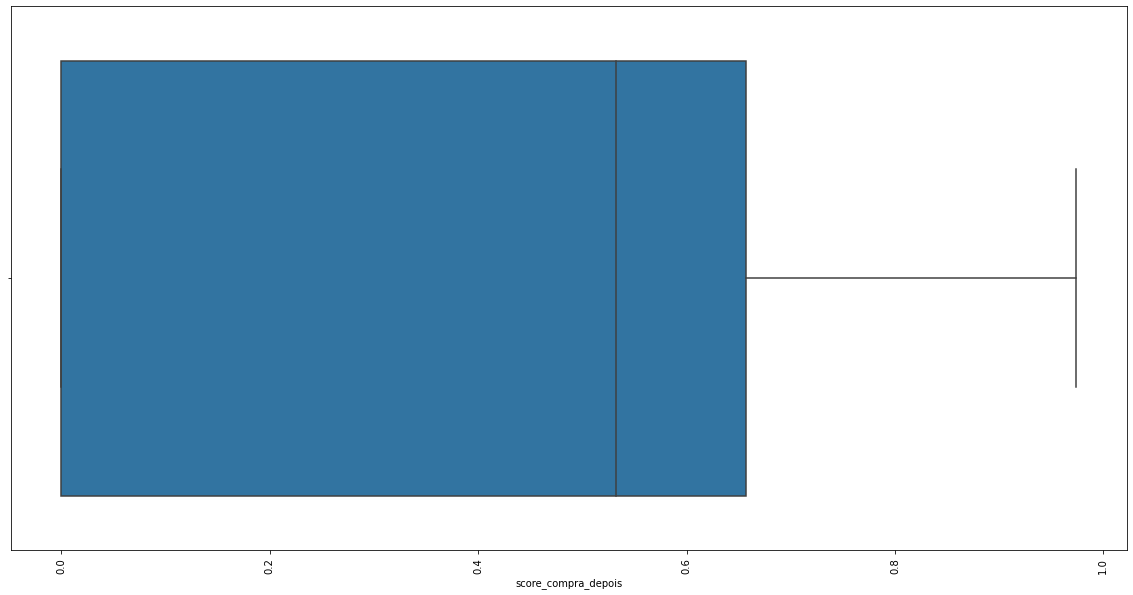

In [32]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df, x = 'score_compra_depois')
plt.xticks(rotation=90)
plt.show()

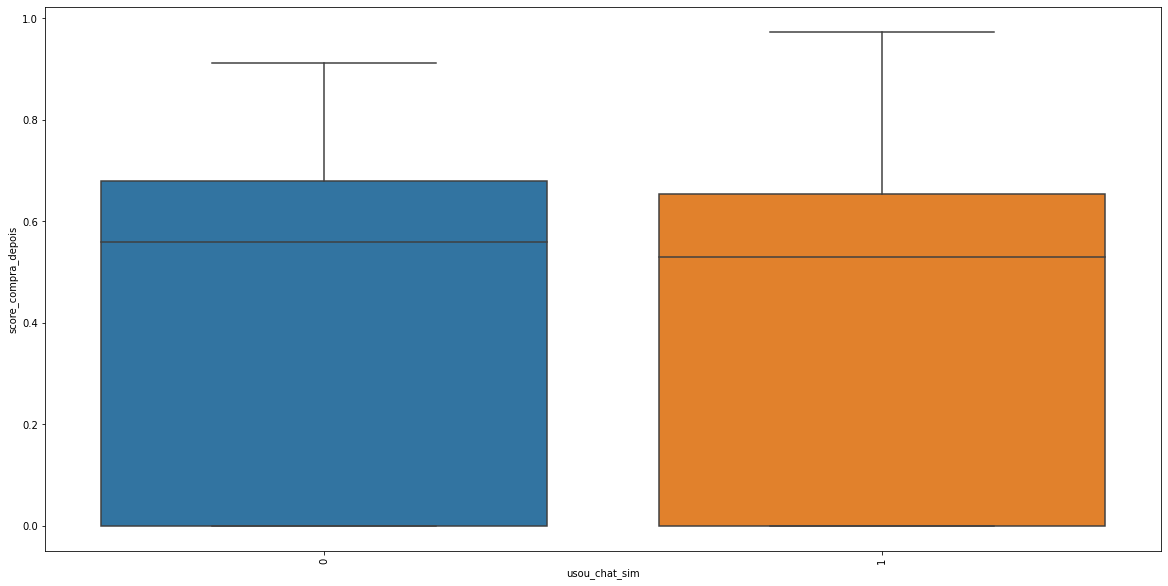

In [33]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df, y = 'score_compra_depois', x = 'usou_chat_sim')
plt.xticks(rotation=90)
plt.show()

In [34]:
df['score_evasao'] = 1- df['score_compra_depois']

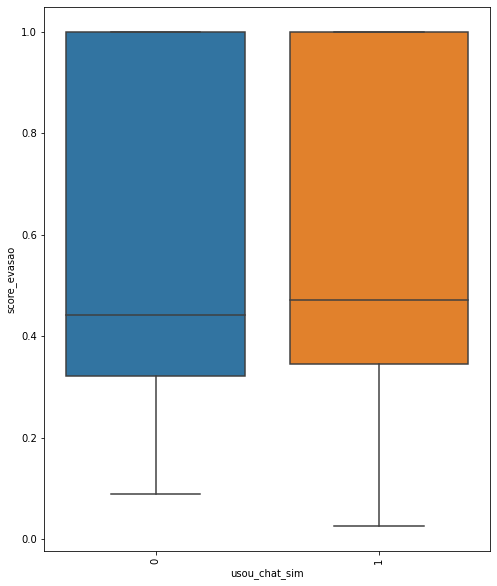

In [35]:
plt.figure(figsize = (8,10))
sns.boxplot(data = df, y = 'score_evasao', x = 'usou_chat_sim')
plt.xticks(rotation=90)
plt.show()

In [39]:
df['score_compra_depois'].max() - df['score_compra_depois'].min()

0.9737608797433462

In [40]:
df.teve_compra_depois.value_counts()

1    113917
0     69540
Name: teve_compra_depois, dtype: int64

In [41]:
df['fx_score'] = np.round(df['score_compra_depois'],1)
df[['teve_compra_depois', 'fx_score']].groupby('fx_score').mean()

,teve_compra_depois
fx_score,
0.0,0.005034
0.1,0.506627
0.2,0.622349
0.3,0.719409
0.4,0.782082
0.5,0.844915
0.6,0.891390
0.7,0.932762
0.8,0.952333


In [42]:
agg_df_compra_sim = df[df['teve_compra_depois'] == 1][['fx_score', 'cpf']].groupby('fx_score').count()
agg_df_compra_nao = df[df['teve_compra_depois'] == 0][['fx_score', 'cpf']].groupby('fx_score').count()

agg_df_compra = agg_df_compra_sim.join(agg_df_compra_nao, lsuffix='sim', rsuffix='nao')
agg_df_compra = agg_df_compra.reset_index()
agg_df_compra['cumperc_nao'] = agg_df_compra['cpfnao'].cumsum()/agg_df_compra['cpfnao'].sum()*100
agg_df_compra['cumperc_sim'] = agg_df_compra['cpfsim'].cumsum()/agg_df_compra['cpfsim'].sum()*100
agg_df_compra['dif'] = agg_df_compra['cumperc_nao'] - agg_df_compra['cumperc_sim']
agg_df_compra['dif_abs'] = np.abs(agg_df_compra['dif'])
# tabela de taxa de compra por fx-score para o ppt

agg_df_compra

,fx_score,cpfsim,cpfnao,cumperc_nao,cumperc_sim,dif,dif_abs
0,0.0,260,51387.0,73.895600,0.228236,73.667363,73.667363
1,0.1,2370,2308.0,77.214553,2.308698,74.905854,74.905854
2,0.2,2846,1727.0,79.698016,4.807009,74.891007,74.891007
3,0.3,4574,1784.0,82.263445,8.822213,73.441233,73.441233
4,0.4,7551,2104.0,85.289042,15.450723,69.838319,69.838319
5,0.5,16159,2966.0,89.554213,29.635612,59.918602,59.918602
6,0.6,33822,4121.0,95.480299,59.325649,36.154650,36.154650
7,0.7,37539,2706.0,99.371585,92.278589,7.092996,7.092996
8,0.8,8511,426.0,99.984182,99.749818,0.234364,0.234364
9,0.9,284,11.0,100.000000,99.999122,0.000878,0.000878


In [43]:
#qtos clientes foram escolhidos ao acaso para não ter atendimento?

print(len(df.query('usou_chat_sim == 0')))

18555


In [44]:
print(len(df.query('usou_chat_sim == 0 & teve_compra_depois == 0')))

6986


In [45]:
# diferença de score entre clientes com e sem atendimento

df.groupby('usou_chat_sim')["score_compra_depois"].mean()

usou_chat_sim
0    0.426786
1    0.407020
Name: score_compra_depois, dtype: float64

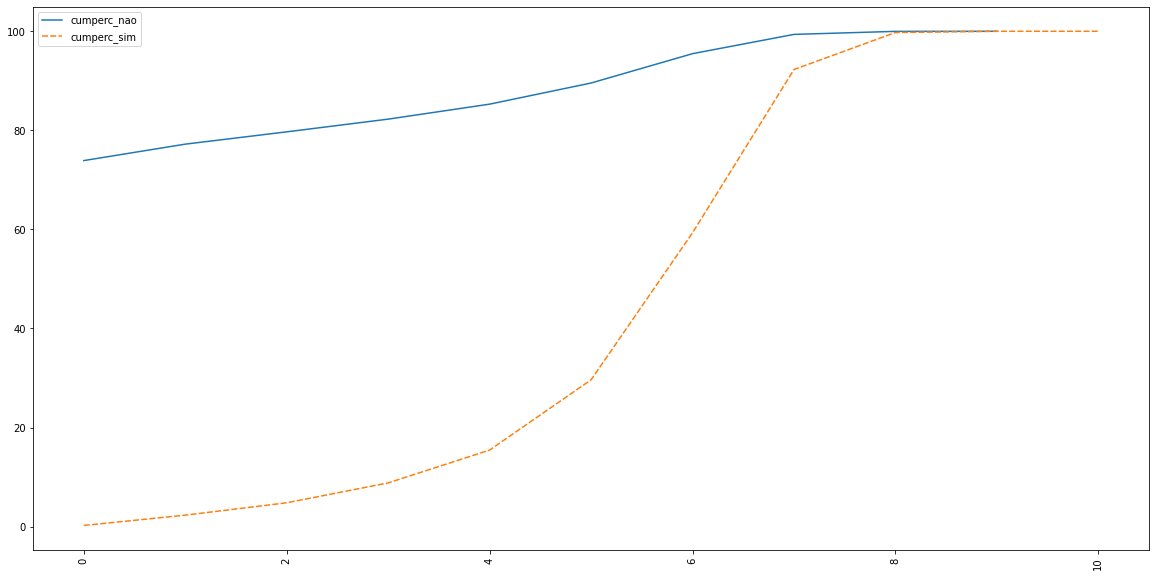

In [46]:
plt.figure(figsize = (20,10))
sns.lineplot(data = agg_df_compra[['cumperc_nao', 'cumperc_sim']])
plt.xticks(rotation=90)
plt.show()

In [47]:
dif_maxima = agg_df_compra['dif_abs'].max()

threshould_conservador = agg_df_compra[agg_df_compra.dif_abs == dif_maxima]['fx_score'].min()

print(threshould_conservador)

0.1


In [48]:
df['compra_depois_propensao']  = np.where(df['fx_score'] > threshould_conservador, 1,0)

print(len(df.query('compra_depois_propensao == 1')))
print(len(df.query('compra_depois_propensao == 0')))


127132
56325


In [49]:
#inputando spending para o cliente que teve churn de fato, que foi sorteado para não ter atendimento na simulação e com baixo score de compra depois
df['flag_atribui_spending'] = np.where((df['compra_depois_propensao'] == 1) & (df['teve_compra_depois'] == 0) & (df.usou_chat_sim == 0),1,0)

print(f"Temos {len(df.query('teve_compra_depois == 0 & usou_chat_sim == 0 & compra_depois_propensao == 0'))} clientes dentre os sorteados para não ter atendimento e não tiveram compra que tem ainda tem chance de churn (vou descartar)")

print(f"vou atribuir spending para {len(df.query('flag_atribui_spending == 1'))} clientes")

Temos 5324 clientes dentre os sorteados para não ter atendimento e não tiveram compra que tem ainda tem chance de churn (vou descartar)
vou atribuir spending para 1662 clientes


In [50]:
for column in vars_rfm:
  if df[column].dtype == 'float' or df[column].dtype == 'int':
    nm_col = column + "_fx"
    df[nm_col] = pd.qcut(df[column].rank(method='first'), q=3, precision=0, labels = ['A', 'B', 'C'])


df['segmento'] = df.cc_time_fx.astype("string") + df.dias_desde_ultima_compra_fx.astype("string") + df.qt_compra_antes_90d_fx.astype("string") + df.vl_compra_antes_90d_fx.astype("string")

df['segmento'].value_counts()

BBAA    50994
CACC    17741
ACBB    11167
AABB     8412
CCBB     7931
        ...  
AACA        7
CCCA        3
BBAC        3
BACA        1
CBCA        1
Name: segmento, Length: 77, dtype: Int64

In [51]:
tabela_churn.to_csv('tabela_churn.csv', index=False)

In [52]:
df = df.join(tabela_churn.set_index('segmento'), on = 'segmento', how = 'left' )

In [53]:
df_comprou = df.query('teve_compra_depois == 1')

formula_text = ("""
vl_compra_depois_60d ~ 
C(periodo_depois30_fim) + 
qt_compra_antes_90d +  vl_current_limit + 
C(ds_gender) + C(ds_state_abbreviation) + C(ds_schooling) + 
C(ds_marital_status) + cc_time + dias_ativacao + 
C(ds_city_size) + vl_compra_antes_90d + vl_renda_declarada  + dias_uso_app
""")

model = ols(formula = formula_text, data = df_comprou).fit()
df_nao_comprou = df.query('flag_atribui_spending == 1')

print(len(df_nao_comprou))

for column in df_nao_comprou.columns:
    if df_nao_comprou[column].dtype == 'object':
        df_nao_comprou[column].fillna(df_nao_comprou[column].mode()[0], inplace = True)
    elif df_nao_comprou[column].dtype == 'string':
        pass
    elif df_nao_comprou[column].dtype == 'category':
        pass
    elif df_nao_comprou[column].dtype == 'datetime64[ns]':
        pass
    elif df_nao_comprou[column].dtype != 'object':
        df_nao_comprou[column].fillna(df_nao_comprou[column].median(), inplace = True)

prediction = model.predict(df_nao_comprou)

incremento_total = prediction.sum()

df_nao_comprou['valor incremental bruto'] = prediction
df_nao_comprou['valor incremental bruto'] = np.where(df_nao_comprou['valor incremental bruto'] >  df_nao_comprou['vl_current_limit'], df_nao_comprou['vl_current_limit'], df_nao_comprou['valor incremental bruto'])


1662


/tmp/ipykernel_846869/585532381.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column].fillna(df_nao_comprou[column].mode()[0], inplace = True)
/tmp/ipykernel_846869/585532381.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column].fillna(df_nao_comprou[column].mode()[0], inplace = True)
/tmp/ipykernel_846869/585532381.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column].f

In [54]:
df_nao_comprou['LTV Bruto'] = (df_nao_comprou['valor incremental bruto'] / 2) * df_nao_comprou['LT']

/tmp/ipykernel_846869/473920939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou['LTV Bruto'] = (df_nao_comprou['valor incremental bruto'] / 2) * df_nao_comprou['LT']


# Calculos para LTV LÍQUIDO

In [55]:
df_nao_comprou['Percentual ITR'] = np.where(df_nao_comprou['spending_ltv'] == 0, 0.014, df_nao_comprou['rec_itr'] / df_nao_comprou['spending_ltv'])


/tmp/ipykernel_846869/3533183355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou['Percentual ITR'] = np.where(df_nao_comprou['spending_ltv'] == 0, 0.014, df_nao_comprou['rec_itr'] / df_nao_comprou['spending_ltv'])


In [56]:
df_nao_comprou['Percentual ITR'].describe()

count    1662.000000
mean        0.014253
std         0.000250
min         0.014000
25%         0.014000
50%         0.014500
75%         0.014500
max         0.014500
Name: Percentual ITR, dtype: float64

In [57]:
df_nao_comprou['LTV Receita Valor'] = (df_nao_comprou['Percentual ITR'] * df_nao_comprou['LTV Bruto'])
+ df_nao_comprou.rec_recarga + df_nao_comprou.rec_demais_encargos + df_nao_comprou.desp_pdd + df_nao_comprou.rec_juros + df_nao_comprou.custos


/tmp/ipykernel_846869/197665048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou['LTV Receita Valor'] = (df_nao_comprou['Percentual ITR'] * df_nao_comprou['LTV Bruto'])


60          0.000000
100        22.180000
137        17.720000
173        -7.756564
245        12.360165
             ...    
183049    123.670000
183063      9.733944
183276      1.000000
183308    262.591065
183411      1.000000
Length: 1662, dtype: float64

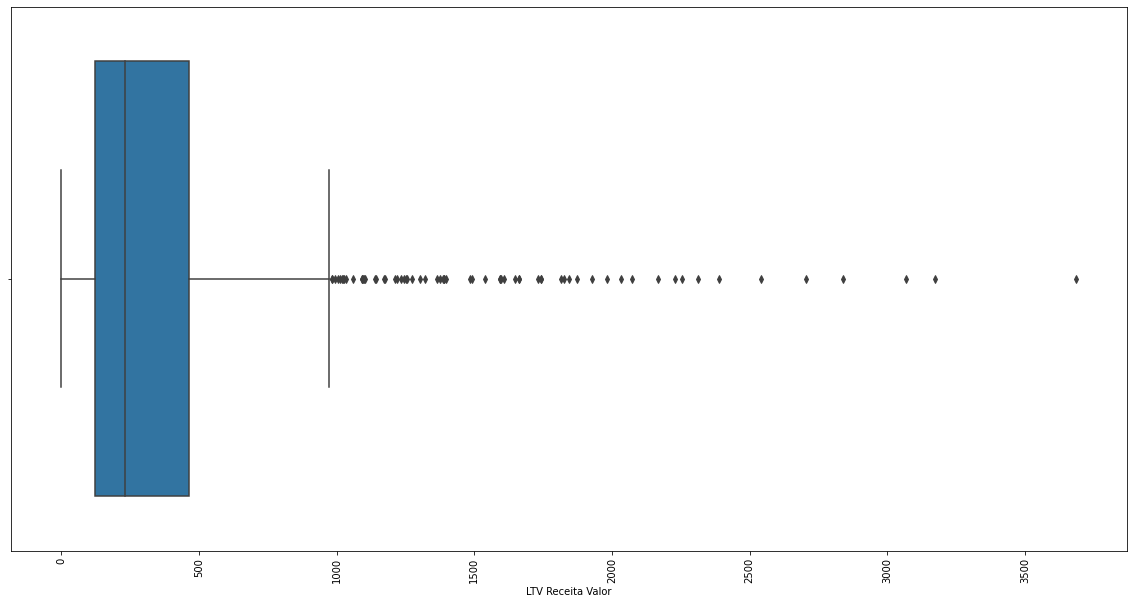

In [58]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_nao_comprou.query('dt_mes_true == "2023-01-01"'), x = 'LTV Receita Valor')
plt.xticks(rotation=90)
plt.show()

In [59]:
df_nao_comprou['LTV Receita Valor_base'] = df_nao_comprou['ltv'] * df_nao_comprou['LT']

/tmp/ipykernel_846869/3119689617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou['LTV Receita Valor_base'] = df_nao_comprou['ltv'] * df_nao_comprou['LT']


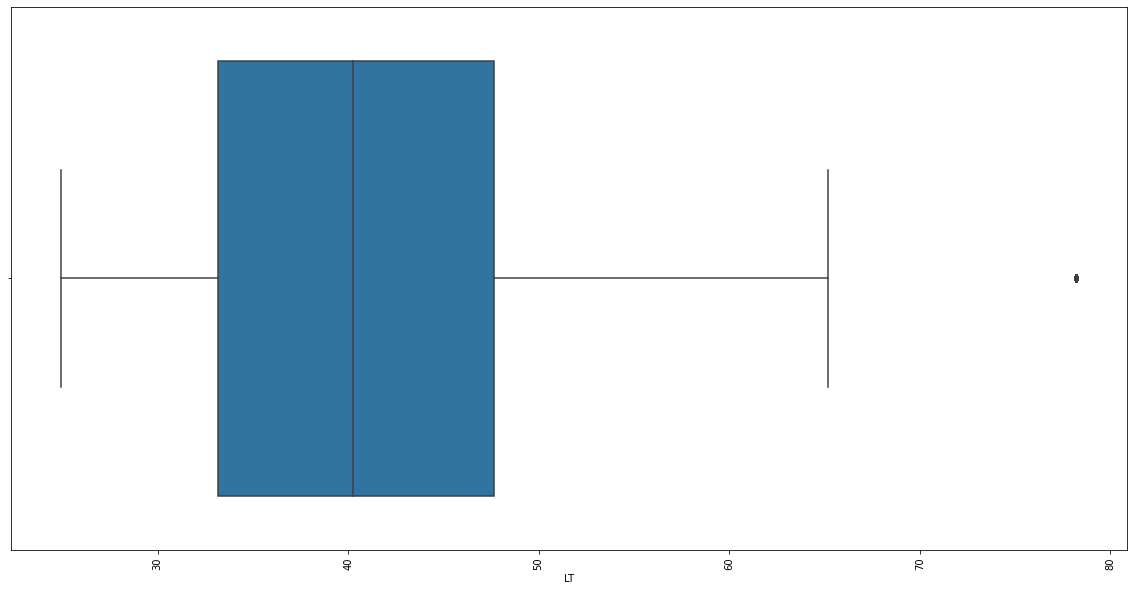

In [60]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_nao_comprou, x = 'LT')
plt.xticks(rotation=90)
plt.show()

In [74]:
df_nao_comprou['LT'].mean()

41.0265045285058

In [61]:
df_nao_comprou['LTV Receita Valor_base'].describe()

count      1662.000000
mean       2696.455549
std       17940.410914
min       -5142.764479
25%           0.000000
50%         169.521663
75%        1564.657791
max      647972.220000
Name: LTV Receita Valor_base, dtype: float64

In [62]:
df_nao_comprou['LTV Receita Valor_base2'] = np.where(df_nao_comprou['LTV Receita Valor_base'] > 3500, 3500, df_nao_comprou['LTV Receita Valor_base'])

/tmp/ipykernel_846869/726066832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou['LTV Receita Valor_base2'] = np.where(df_nao_comprou['LTV Receita Valor_base'] > 3500, 3500, df_nao_comprou['LTV Receita Valor_base'])


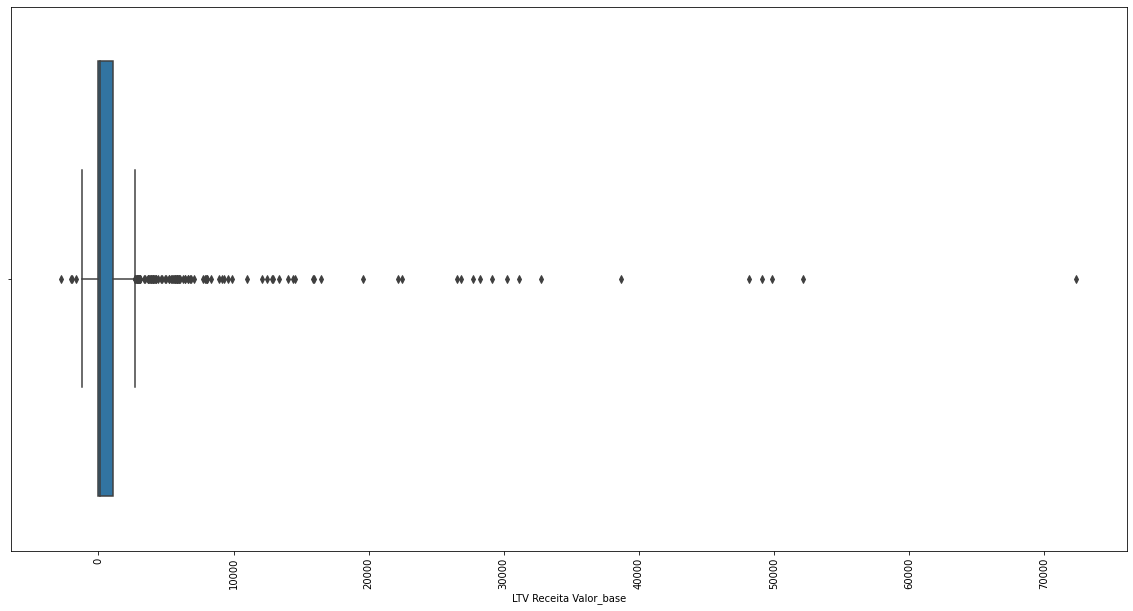

In [63]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_nao_comprou.query('dt_mes_true == "2023-01-01"'), x = 'LTV Receita Valor_base')
plt.xticks(rotation=90)
plt.show()

In [64]:
df_nao_comprou['LTV Receita Valor_base2'].describe()

count    1662.000000
mean      878.065042
std      1343.545990
min     -5142.764479
25%         0.000000
50%       169.521663
75%      1564.657791
max      3500.000000
Name: LTV Receita Valor_base2, dtype: float64

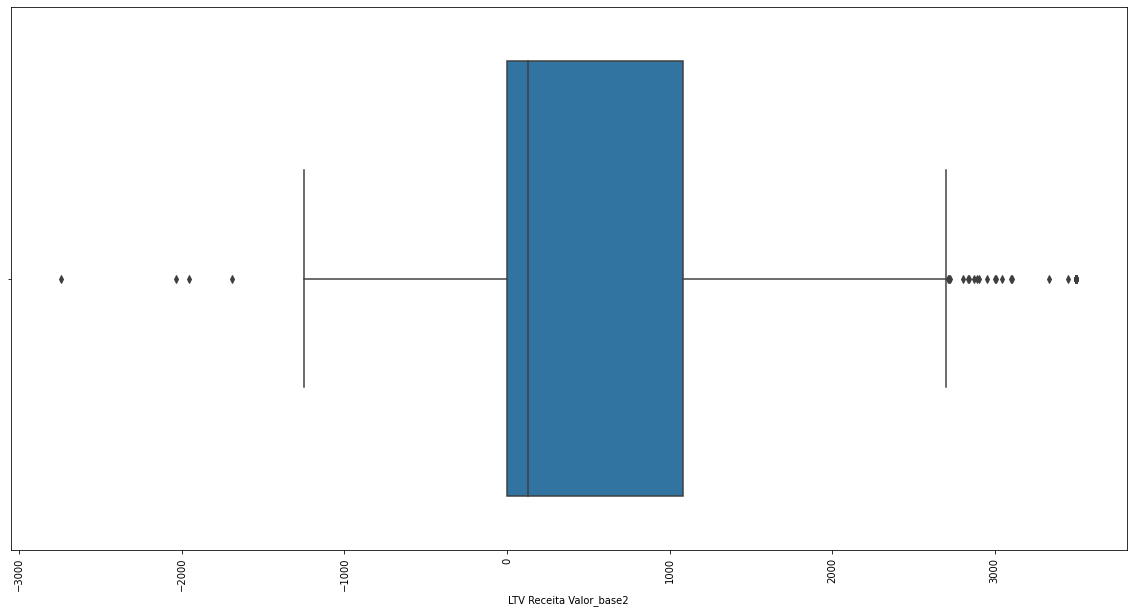

In [65]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_nao_comprou.query('dt_mes_true == "2023-01-01"'), x = 'LTV Receita Valor_base2')
plt.xticks(rotation=90)
plt.show()

In [66]:
#incluir incremento ajustado
resultado_sim = df_nao_comprou[['hierarquia_1', 'valor incremental bruto', 'dt_mes_true', 'LTV Bruto', 'LTV Receita Valor', 'LTV Receita Valor_base', 'LTV Receita Valor_base2']].groupby(['hierarquia_1', 'dt_mes_true']).sum()
resultado_sim = resultado_sim.reset_index()
resultado_sim

,hierarquia_1,dt_mes_true,valor incremental bruto,LTV Bruto,LTV Receita Valor,LTV Receita Valor_base,LTV Receita Valor_base2
0,Assunto não identificado,2023-01-01,1760.000000,2.673876e+04,387.711995,5.503462e+03,5503.462245
1,Assunto não identificado,2023-02-01,9131.834675,1.280764e+05,1811.880324,5.889064e+03,4827.868395
2,Assunto não identificado,2023-03-01,14516.950388,3.393710e+05,4781.410918,3.718007e+04,4425.251456
3,Atendimento,2023-01-01,20122.109761,4.300165e+05,6199.557784,6.990169e+03,4865.060912
4,Atendimento,2023-02-01,15402.327606,4.111963e+05,5879.622170,1.530703e+04,4237.764445
5,Atendimento,2023-03-01,18170.623892,4.706339e+05,6682.169076,9.981335e+04,25249.582718
6,Cartão,2023-01-01,489141.721848,1.146185e+07,163733.391354,6.505524e+05,271049.561918
7,Cartão,2023-02-01,559486.647306,1.307475e+07,186986.613908,8.736332e+05,335787.007857
8,Cartão,2023-03-01,408175.321021,8.985658e+06,128321.741661,1.697869e+06,351364.490865
9,Conta,2023-01-01,44070.164598,9.245502e+05,13181.374629,1.956045e+05,55513.498887


In [67]:
print(len(df_nao_comprou))
print(len(df_nao_comprou['cpf'].unique()))

1662
1654


In [68]:
resultado_sim.groupby('dt_mes_true')['LTV Receita Valor'].sum()

dt_mes_true
2023-01-01    250870.787173
2023-02-01    239110.219331
2023-03-01    193557.617680
Name: LTV Receita Valor, dtype: float64

In [69]:
resultado_sim.groupby('dt_mes_true')['valor incremental bruto'].sum()

dt_mes_true
2023-01-01    752860.916619
2023-02-01    722524.303667
2023-03-01    598315.149938
Name: valor incremental bruto, dtype: float64

In [70]:
resultado_sim.groupby('dt_mes_true')['LTV Bruto'].sum()

dt_mes_true
2023-01-01    1.757482e+07
2023-02-01    1.672498e+07
2023-03-01    1.356368e+07
Name: LTV Bruto, dtype: float64

In [71]:
resultado_sim.groupby('dt_mes_true')['LTV Receita Valor_base'].sum()

dt_mes_true
2023-01-01    1.290825e+06
2023-02-01    1.062821e+06
2023-03-01    2.127864e+06
Name: LTV Receita Valor_base, dtype: float64

In [72]:
resultado_sim.groupby('dt_mes_true')['LTV Receita Valor_base2'].sum()

dt_mes_true
2023-01-01    490326.113193
2023-02-01    434509.261339
2023-03-01    534508.725189
Name: LTV Receita Valor_base2, dtype: float64

In [73]:
len(df_nao_comprou[df_nao_comprou['LTV Receita Valor_base'] == 0])

204